In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import math
from operator import add
import random
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

from ipynb.fs.full.GenerateData import generatedata
from ipynb.fs.full.AnalysisPartFunctions import initialize_parameters,initialize_dicts,calc_prior_mean,calc_post_mean,calc_post_sd,calc_Phi,calc_L,calc_component_derivs,calc_gradients,update_parameters

In [2]:
random.seed(110)

**(a) Generate data**

In [3]:
data = pd.DataFrame(generatedata())

In [4]:
data.head()

,index,id,name,first,last,sex,race,dob,age,age_cat,...,r_charge_desc,r_jail_in,r_jail_out,is_violent_recid,num_vr_cases,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,release
0,0,1,miguel hernandez,miguel,hernandez,Male,Other,1947-04-18 00:00:00.000000,69,Greater than 45,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1
1,1,2,michael ryan,michael,ryan,Male,Caucasian,1985-02-06 00:00:00.000000,31,25 - 45,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0
2,2,3,kevon dixon,kevon,dixon,Male,African-American,1982-01-22 00:00:00.000000,34,25 - 45,...,Felony Battery (Dom Strang),NaN,NaN,1,NaN,13009779CF10A,(F3),2013-07-05 00:00:00.000000,Felony Battery (Dom Strang),1
3,3,4,ed philo,ed,philo,Male,African-American,1991-05-14 00:00:00.000000,24,Less than 25,...,Driving Under The Influence,2013-06-16 09:05:47.000000,2013-06-16 07:18:55.000000,0,NaN,NaN,NaN,NaN,NaN,0
4,4,5,marcu brown,marcu,brown,Male,African-American,1993-01-21 00:00:00.000000,23,Less than 25,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0


check how many released/remanded

In [5]:
data.release.value_counts()

1    6800
0    4942
Name: release, dtype: int64

**(b) Create dummy variables for categorical variables**

In [6]:
sex_dummies = pd.get_dummies(data['sex'])
race_dummies = pd.get_dummies(data['race'])
age_dummies = pd.get_dummies(data['age_cat'])

data['sex_1_male'] = sex_dummies['Male']
data['African_American']=race_dummies['African-American']
data['Asian']=race_dummies['Asian']
data['Caucasian']=race_dummies['Caucasian']
data['Hispanic'] = race_dummies['Hispanic']
data['Native_American']=race_dummies['Native American']
data['race_Other']=race_dummies['Other']
data['Greater_45']=age_dummies['Greater than 45']
data['25_45']=age_dummies['25 - 45']
data['Less_25']=age_dummies['Less than 25']

In [7]:
data.columns

Index(['index', 'id', 'name', 'first', 'last', 'sex', 'race', 'dob', 'age',
       'age_cat', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'compas_screening_date', 'decile_score', 'score_text', 'violent_recid',
       'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_case_number', 'c_days_from_compas', 'c_arrest_date',
       'c_offense_date', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'num_r_cases', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest',
       'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out',
       'is_violent_recid', 'num_vr_cases', 'vr_case_number',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'release',
       'sex_1_male', 'African_American', 'Asian', 'Caucasian', 'Hispanic',
       'Native_American', 'race_Other', 'Greater_45', '25_45', 'Less_25'],
      dtype='object')

**(c) Split data into training & test**

In [8]:
# select out relevant data & generate the train and test data

# train / test
features = ['decile_score','Less_25','25_45','Greater_45','sex_1_male','African_American','Caucasian','is_violent_recid','juv_fel_count']
X = data[features]
y = data['release']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=120)

risk_assess_train = X_train['decile_score']
X_train = X_train.drop(['decile_score'],axis=1)

risk_assess_test = X_test['decile_score']
X_test = X_test.drop(['decile_score'],axis=1)

Define variables for analysis without penalties

In [9]:
X = X_train
Y = y_train.tolist()
mu_ra = risk_assess_train.tolist()
theta = 3
num_int = 2000
learning_rate = 0.1

In [10]:
parameters = initialize_parameters(X_train,1,10)
derivatives,grads = initialize_dicts()

In [11]:
parameters

{'B': array([[0.08917796],
        [0.09613061],
        [0.06527999],
        [0.09355475],
        [0.03978368],
        [0.088232  ],
        [0.0139983 ],
        [0.0251726 ]]),
 'b': 3.034332879278888,
 'q': 0.48782564382181437,
 'sd_prior': 7.448310983600894,
 'tau': 8}

In [13]:
loss = []
j = 0

tracB1 = parameters['B'][0].tolist()
tracB2 = parameters['B'][1].tolist()
tracB3 = parameters['B'][2].tolist()
tracB4 = parameters['B'][3].tolist()
tracb = [parameters['b']]
tracQ = [parameters['q']]
tracT = [parameters['tau']]
tracSD = [parameters['sd_prior']]

while j < num_int:
    
    mu_prior = calc_prior_mean(X, parameters)
    mu_post = calc_post_mean(mu_prior, mu_ra, parameters, theta)
    sd_post =calc_post_sd(mu_prior, mu_ra, parameters, theta)
    Phi = calc_Phi(mu_post, sd_post, parameters)
    L = calc_L(Phi, Y)
    loss.append(L)
        
    derivatives = calc_component_derivs(X,parameters, derivatives, theta, mu_prior,mu_ra,mu_post,sd_post,Phi,Y)
    grads = calc_gradients(X,grads,derivatives)
    parameters = update_parameters(parameters, grads, learning_rate)
    
    tracB1.append(parameters['B'][0])
    tracB2.append(parameters['B'][1])
    tracB3.append(parameters['B'][2])
    tracB4.append(parameters['B'][3])
    tracb.append(parameters['b'])
    tracQ.append(parameters['q'])
    tracT.append(parameters['tau'])
    tracSD.append(parameters['sd_prior'])

    if j%10==0:
        print(L)
    j+=1
        


0.916866592042832
0.9098482645943624
0.9030984363658553
0.896603360962769
0.8903501809186177
0.88432685744325
0.8785221067449986
0.8729253422212113
0.8675266218956725
0.8623166005554495
0.8572864861033516
0.8524279996977404
0.8477333393009374
0.8431951462995542
0.8388064748968392
0.8345607640119218
0.8304518114473429
0.8264737501132892
0.8226210261189175
0.818888378560143
0.8152708208526837
0.8117636234724257
0.8083622979802683
0.805062582221082
0.8018604265959137
0.7987519813177707
0.7957335845688227
0.7928017514855099
0.7899531639042274
0.7871846608063774
0.7844932294083979
0.7818759968454025
0.7793302224033686
0.7768532902573257
0.7744427026781195
0.7720960736722992
0.7698111230232456
0.7675856707046396
0.7654176316389911
0.7633050107769704
0.7612458984745554
0.7592384661476437
0.7572809621844364
0.7553717080986855
0.7535090949064468
0.751691579712586
0.7499176824921795
0.7481859830543022
0.7464951181765955
0.7448437788992159
0.743230707968164
0.7416546974184892
0.7401145862888902
0

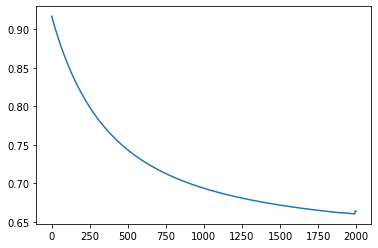

In [14]:
plt.plot(loss)

In [15]:
mu_post

[2.8899873611522287,
 3.9988847990656273,
 3.912543651634265,
 3.1335980979852556,
 3.2077407640091313,
 3.8925805054739038,
 3.9988847990656273,
 4.0027439024378815,
 4.483821911877232,
 2.7012780031487007,
 4.034683895961033,
 2.9840187844503605,
 3.415131113998561,
 4.58143071884434,
 4.0027439024378815,
 3.9983146715396805,
 3.9983146715396805,
 3.7087016302898252,
 4.618706486617356,
 2.8899873611522287,
 2.7754206691725765,
 2.89291823341394,
 3.6830743147473055,
 2.8899873611522287,
 4.678393014404184,
 3.322307455988783,
 2.792378554185121,
 3.8100069488794315,
 3.660596127527205,
 3.9450600158022224,
 2.8694520924707088,
 3.912543651634265,
 3.912543651634265,
 3.322307455988783,
 4.111428651190405,
 2.7012780031487007,
 2.89291823341394,
 4.33717347060405,
 3.1509851084840146,
 2.7012780031487007,
 3.2655518004636663,
 3.7504889132752712,
 4.0027439024378815,
 3.2077407640091313,
 4.0325457106687415,
 3.825177705234434,
 3.9988847990656273,
 3.9983146715396805,
 3.90485337576

(array([ 616., 1163., 1130.,  738., 1631., 2107.,  647.,  654.,    3.,
         117.]),
 array([2.58378044, 2.8508434 , 3.11790637, 3.38496933, 3.6520323 ,
        3.91909527, 4.18615823, 4.4532212 , 4.72028416, 4.98734713,
        5.25441009]),
 <a list of 10 Patch objects>)

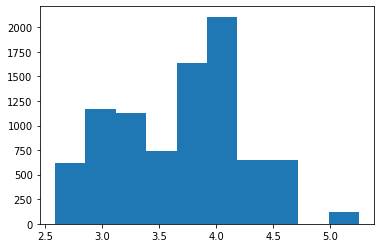

In [16]:
plt.hist(mu_post)

In [17]:
parameters

{'B': array([[0.15918767],
        [0.24499812],
        [0.10283908],
        [0.28971112],
        [0.17320368],
        [0.17761089],
        [0.03424116],
        [0.03637483]]),
 'b': 3.2907691948619187,
 'q': 1.956789721643414,
 'sd_prior': 7.788591656617729,
 'tau': 7.276487873684616}

(array([1.120e+02, 7.990e+02, 1.397e+03, 1.917e+03, 1.283e+03, 3.276e+03,
        1.700e+01, 2.000e+00, 2.000e+00, 1.000e+00]),
 array([3.39346127, 3.51279447, 3.63212767, 3.75146086, 3.87079406,
        3.99012725, 4.10946045, 4.22879365, 4.34812684, 4.46746004,
        4.58679323]),
 <a list of 10 Patch objects>)

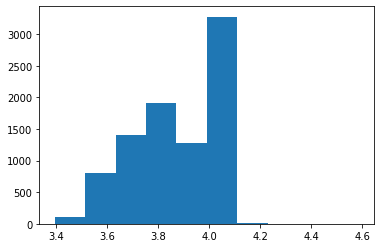

In [18]:
plt.hist(mu_prior)

In [ ]:
parameters

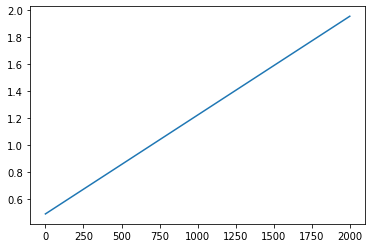

In [24]:
plt.plot(tracQ)

In [ ]:
tracB1.append(parameters['B'][0])
    tracB2.append(parameters['B'][1])
    tracB3.append(parameters['B'][2])
    tracB4.append(parameters['B'][3])
    tracb.append(parameters['b'])
    tracQ.append(parameters['q'])
    tracT.append(parameters['tau'])
    tracSD.append(parameters['sd_prior'])

Define variables for analysis with penalties

In [ ]:
parameters = initialize_parameters(X_test,1,10)
derivatives,grads = initialize_dicts()

X = X_train
y = np.array(y_train)
mu_ra = np.array(risk_assess_train)
theta = 5
num_int = 100
learning_rate = 0.001
k = 1

In [ ]:
parameters

In [ ]:
loss = []
j = 0

while j < num_int:
    
    var_prior = parameters['var_prior'][0]
    q = parameters['q'][0]
    tau = parameters['tau']
        
    mu_prior = calc_prior_mean(X, parameters)[0]
    mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
    var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
    Phi = calc_Phi(mu_post, var_post, tau)
    L = calc_L(Phi, y, mu_prior, k)
    loss.append(np.sum(L))
        
    if j%%5==0:
        print(L)
        
    derivatives = calc_component_derivs(X, y, parameters, derivatives, theta, mu_prior, mu_ra, mu_post, var_post, Phi, k)
    grads = calc_gradients(grads, derivatives, mu_prior, X)
    parameters = update_parameters(parameters, grads, learning_rate)
    
    j+=1
        


In [ ]:
loss

In [ ]:
loss = []

var_prior = parameters['var_prior'][0]
q = parameters['q'][0]
tau = parameters['tau']

mu_prior = calc_prior_mean(X, parameters)[0]
mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
Phi = calc_Phi(mu_post, var_post, tau)
L = calc_L(Phi, y, mu_prior, k)
loss.append(np.sum(L))
        
derivatives = calc_component_derivs(X, y, parameters, derivatives, theta, mu_prior, mu_ra, mu_post, var_post, Phi, k)
grads = calc_gradients(grads, derivatives, mu_prior, X)
parameters = update_parameters(parameters, grads, learning_rate)

In [ ]:
print("B: ",parameters['B'])
print("b: ",parameters['b'])
print("q: ",parameters['q'])
print("var_prior: ",parameters['var_prior'])
print("tau: ",parameters['tau'])
print("loss: ",loss)
print("mu_prior: ",np.min(mu_prior),"to",np.max(mu_prior))
print("mu_post: ",np.min(mu_post),"to",np.max(mu_post))
print("Phi: ", np.min(Phi),"to",np.max(Phi))

In [ ]:
parameters

In [ ]:
var_prior = parameters['var_prior'][0]
q = parameters['q'][0]
tau = parameters['tau']

In [ ]:
mu_prior = calc_prior_mean(X, parameters)[0]
mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
Phi = calc_Phi(mu_post, var_post, tau)
L = calc_L(Phi, y, mu_prior, k)

In [ ]:
mu_prior

In [ ]:
test1 = 10*((1-mu_prior)**3)
test2 = y_train*np.log(1-Phi)+(1-y)*np.log(Phi)
test = test1 + test2
test

In [ ]:
loss.append(np.sum(L))
        
derivatives = calc_component_derivs(X, y, parameters, derivatives, theta, mu_prior, mu_ra, mu_post, var_post, Phi, k)
grads = calc_gradients(grads, derivatives, mu_prior, X)
parameters = update_parameters(parameters, grads, learning_rate)

In [ ]:
parameters

In [ ]:
derivatives

In [ ]:
"""
# Predict test/train set examples 
#y_pred_train = predict(parameters,X_train,y_train,risk_assess_train,theta=5)
#y_pred_test = predict(parameters,X_test,y_test,risk_assess_test,theta=5)

# Print train/test Errors
# general accuracy
print("train accuracy: {} %".format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

# confusion matrix
confmat = []

for true,pred in zip(y_train,y_pred_train):
    if(true==1 and pred==1):
        confmat.append("tp")
    elif(true==1 and pred==0):
        confmat.append("fn")
    elif(true==0 and pred==0):
        confmat.append("tn")
    else:
        confmat.append(fp)

print("true positives: ",confmat.count('tp'))
print("false positives: ",confmat.count('fp'))
print("true negatives: ",confmat.count('tn'))
print("false negatives: ",confmat.count('fn'))

if (confmat.count('tp')+confmat.count('fn'))>0:
    print("sensitivity/recall: ",confmat.count('tp')/(confmat.count('tp')+confmat.count('fn')))
else:
    print("sensitivity/recall: N/A")
    
if (confmat.count('tn')+confmat.count('fp'))>0:
    print("specificity: ",confmat.count('tn')/(confmat.count('tn')+confmat.count('fp')))
else:
    print("specificity: N/A")
    
if (confmat.count('tp')+confmat.count('fp'))>0:
    print("precision: ",confmat.count('tp')/(confmat.count('tp')+confmat.count('fp')))
else:
    print("precision: N/A")
    
model_dict = {"nLL": L,
              "y_pred_test": y_pred_test,
              "y_pred_train" : y_pred_train,
              "parameters" : parameters
              "learning_rate" : learning_rate,
              "num_iterations": num_iterations}

#return model_dict
"""

In [ ]:
def training_model(X,y,parameters,mu_ra,theta,num_int,learning_rate,k):
    
    mu_ra = np.array(mu_ra)
    y=np.array(y)
    loss = []
    j = 0
    
    while j < num_int:
        
        var_prior = parameters['var_prior'][0]
        q = parameters['q'][0]
        tau = parameters['tau']
        
        mu_prior = calc_prior_mean(X, parameters)[0]
        mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
        var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
        Phi = calc_Phi(mu_post, var_post, tau)
        L = calc_L(Phi, y, mu_prior, k)
        loss.append(np.sum(L))
        
        derivatives = calc_component_derivs(X, parameters, theta, mu_prior, mu_ra, mu_post, var_post, Phi, k)
        grads = calc_gradients(derivatives, mu_prior, X)
        parameters = update_parameters(parameters, grads, learning_rate)
        #print(parameters)
        j+=1
        
    return loss, parameters, derivatives, grads

In [ ]:
def predict(parameters,X,y,risk_assess,theta):
    
    tau = parameters['tau']
    q = parameters['q']
    mu_ra = np.array(risk_assess)
    mu_prior = calc_prior_mean(X,parameters)[0]
    var_prior = parameters['var_prior']
    #var_ra = calc_var_ra(var_prior,mu_prior,mu_ra,q,theta)
    
    mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
    var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
    Phi = calc_Phi(mu_post,var_post,tau)
    #L = calc_L(Phi,y)
    
    y_pred = [1 if Phi[i]>0.5 else 0 for i in range(len(Phi))]
    
    return y_pred